In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:

# Load the metadata file
metadata = pd.read_csv(r'..\starting_metadata\metadata.csv')

# Select rows where 'filename_index' contains 'train'
train_files = metadata[metadata['filename_index'].str.contains('train', na=False)]


# Select only rows with all metadata (i.e., no missing values)
train_files_with_all_metadata = train_files.dropna()

train_files_with_all_metadata

,filename_index,Habitat,Latitude,Longitude,Substrate,eventDate,taxonID_index
10181,fungi_train000029.jpg,Unmanaged deciduous woodland,55.065148,10.530815,soil,2020-08-02,2.0
10200,fungi_train000048.jpg,Unmanaged deciduous woodland,55.386461,9.619818,dead wood (including bark),2020-10-25,39.0
10204,fungi_train000052.jpg,Bog woodland,56.259944,10.640972,mosses,2019-06-15,168.0
10220,fungi_train000068.jpg,Deciduous woodland,56.021797,12.293118,soil,2018-09-17,0.0
10224,fungi_train000072.jpg,coniferous woodland/plantation,54.790414,11.882475,soil,2020-12-04,24.0
...,...,...,...,...,...,...,...
35704,fungi_train025552.jpg,dune,56.874640,8.298630,soil,2013-11-02,115.0
35707,fungi_train025555.jpg,Unmanaged deciduous woodland,56.636300,9.844050,soil,2018-08-19,98.0
35731,fungi_train025579.jpg,Mixed woodland (with coniferous and deciduous ...,55.622314,8.549370,soil,2019-09-03,66.0
35806,fungi_train025654.jpg,Deciduous woodland,55.770300,12.401400,soil,2020-09-29,17.0


In [9]:
print(f"Total number of training files with all metadata: {len(train_files_with_all_metadata)}")

Total number of training files with all metadata: 914


C:\Users\ngrec\AppData\Local\Temp\ipykernel_13140\2033683316.py:26: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


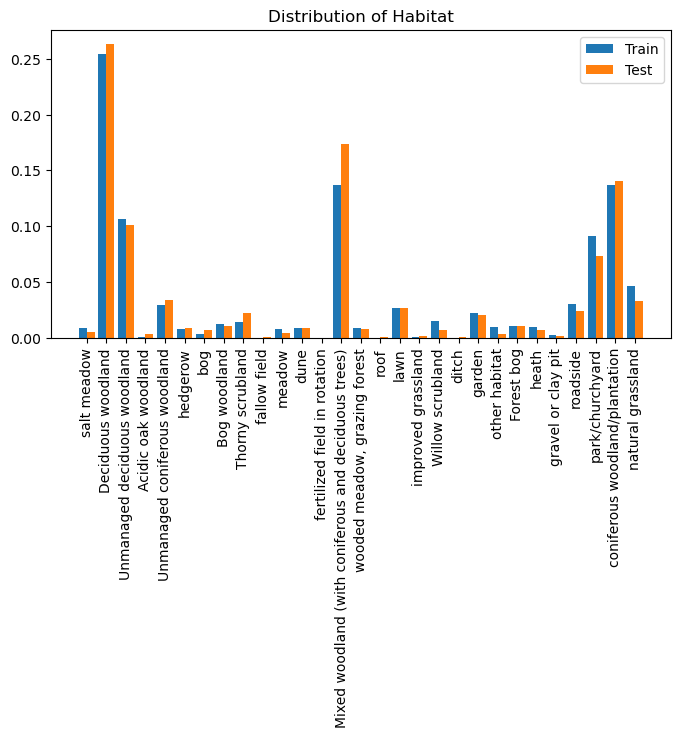

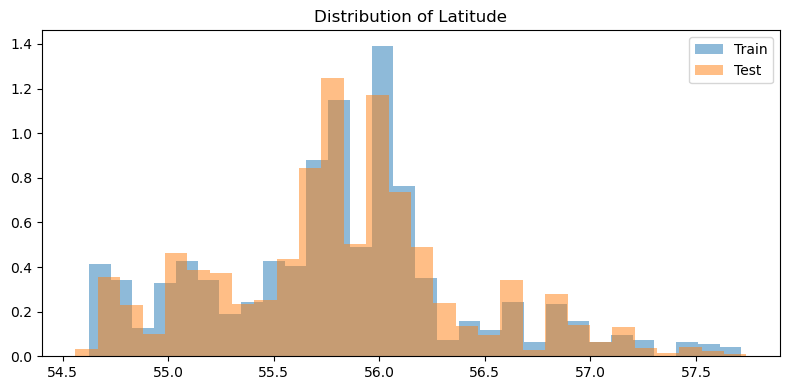

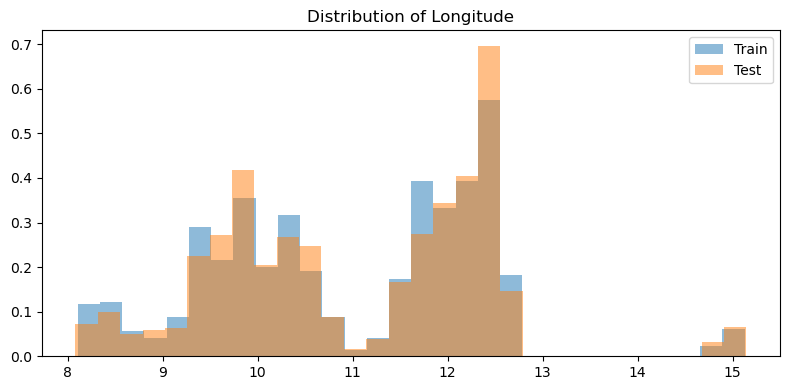

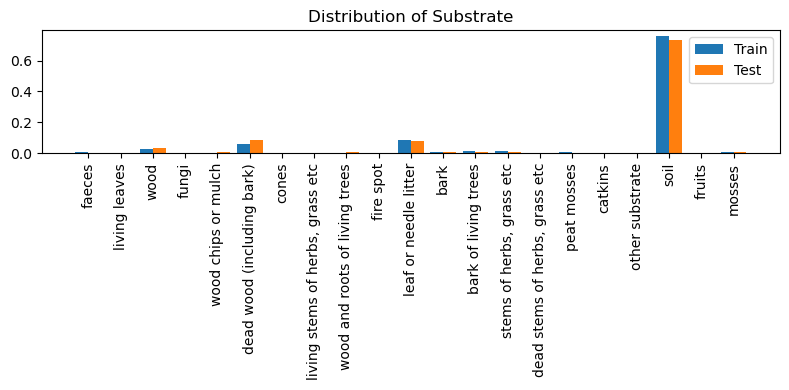

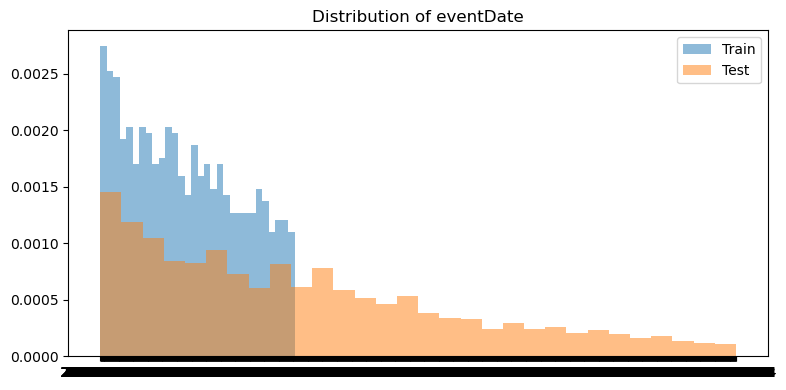

In [8]:
# Select test files (those not containing 'train' in filename_index)
test_files = metadata[~metadata['filename_index'].str.contains('train', na=False)]

# Compare distributions for selected metadata columns
cols_to_compare = ['Habitat', 'Latitude', 'Longitude', 'Substrate', 'eventDate']

import matplotlib.pyplot as plt

for col in cols_to_compare:
    plt.figure(figsize=(8, 4))
    if col in ['Latitude', 'Longitude', 'eventDate']:
        plt.hist(train_files_with_all_metadata[col], bins=30, alpha=0.5, label='Train', density=True)
        plt.hist(test_files[col].dropna(), bins=30, alpha=0.5, label='Test', density=True)
    else:
        train_counts = train_files_with_all_metadata[col].value_counts(normalize=True)
        test_counts = test_files[col].value_counts(normalize=True)
        all_categories = set(train_counts.index).union(set(test_counts.index))
        train_vals = [train_counts.get(cat, 0) for cat in all_categories]
        test_vals = [test_counts.get(cat, 0) for cat in all_categories]
        x = range(len(all_categories))
        plt.bar(x, train_vals, width=0.4, label='Train', align='center')
        plt.bar([i + 0.4 for i in x], test_vals, width=0.4, label='Test', align='center')
        plt.xticks([i + 0.2 for i in x], list(all_categories), rotation=90)
    plt.title(f'Distribution of {col}')
    plt.legend()
    plt.tight_layout()
    plt.show()

    geohash                                            Habitat  \
4     u1vu9                      Unmanaged coniferous woodland   
9     u1vv5                     coniferous woodland/plantation   
11    u1vvd                                   Willow scrubland   
14    u1vz0  Mixed woodland (with coniferous and deciduous ...   
19    u1vzx  Mixed woodland (with coniferous and deciduous ...   
..      ...                                                ...   
425   u4p52                                 Deciduous woodland   
432   u4p9m                     coniferous woodland/plantation   
438   u4pk1                     coniferous woodland/plantation   
440   u4pm6                                       Bog woodland   
446   u4pqv                                 Deciduous woodland   

                 Substrate  unique_habitats  unique_substrates  
4    leaf or needle litter                1                  2  
9                     soil                2                  1  
11          

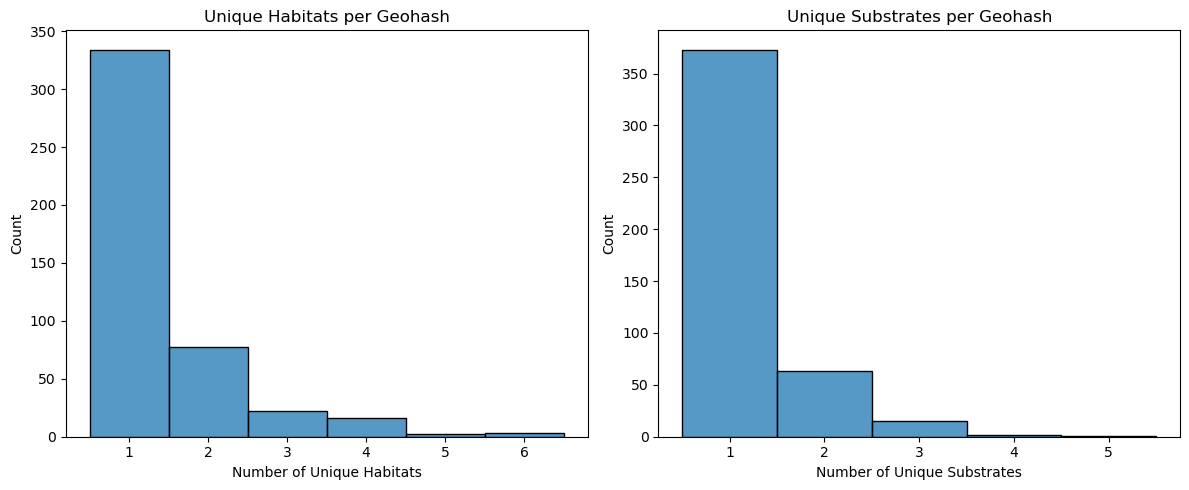

In [48]:
import seaborn as sns

# Check if mushrooms in close proximity have similar habitat and substrate

# We'll use geohash to define "close proximity" (already computed in df_feat['geohash'])
# For each geohash, check the most common habitat and substrate

proximity_stats = (
    df_feat.groupby('geohash')[['Habitat', 'Substrate']]
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
    .reset_index()
)

# Count unique habitats and substrates per geohash
proximity_counts = (
    df_feat.groupby('geohash')[['Habitat', 'Substrate']]
    .nunique()
    .rename(columns={'Habitat': 'unique_habitats', 'Substrate': 'unique_substrates'})
    .reset_index()
)

# Merge stats and counts
proximity_summary = pd.merge(proximity_stats, proximity_counts, on='geohash')

# Show geohashes with more than one unique habitat or substrate
print(proximity_summary[ (proximity_summary['unique_habitats'] > 1) | (proximity_summary['unique_substrates'] > 1) ])

# Show overall distribution
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(proximity_summary['unique_habitats'], bins=range(1, proximity_summary['unique_habitats'].max()+2), ax=axes[0], discrete=True)
axes[0].set_title('Unique Habitats per Geohash')
axes[0].set_xlabel('Number of Unique Habitats')
axes[0].set_ylabel('Count')

sns.histplot(proximity_summary['unique_substrates'], bins=range(1, proximity_summary['unique_substrates'].max()+2), ax=axes[1], discrete=True)
axes[1].set_title('Unique Substrates per Geohash')
axes[1].set_xlabel('Number of Unique Substrates')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

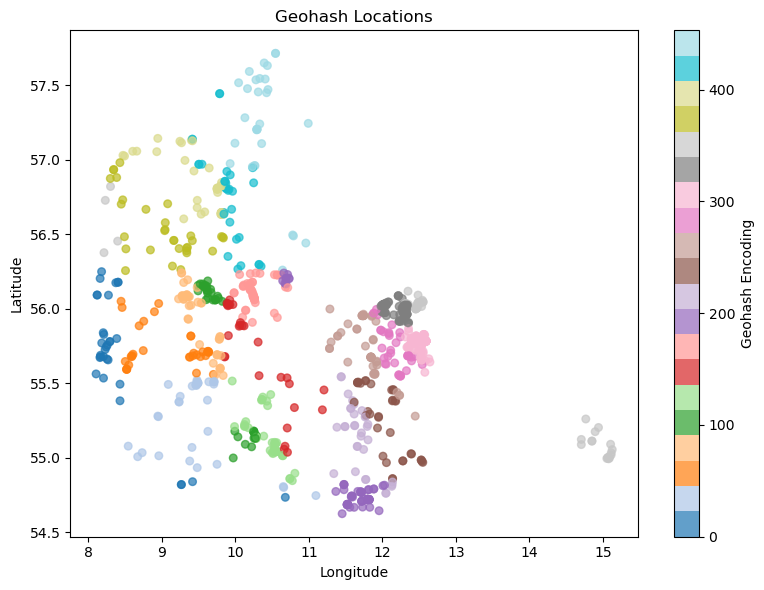

In [ ]:
import matplotlib.pyplot as plt

# Plot geohash locations as a scatter plot (map-like)
plt.figure(figsize=(8, 6))
plt.scatter(df_feat['Longitude'], df_feat['Latitude'], c=df_feat['geohash_enc'], cmap='tab20', s=30, alpha=0.7)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geohash Locations')
plt.colorbar(label='Geohash Encoding')
plt.tight_layout()
plt.show()

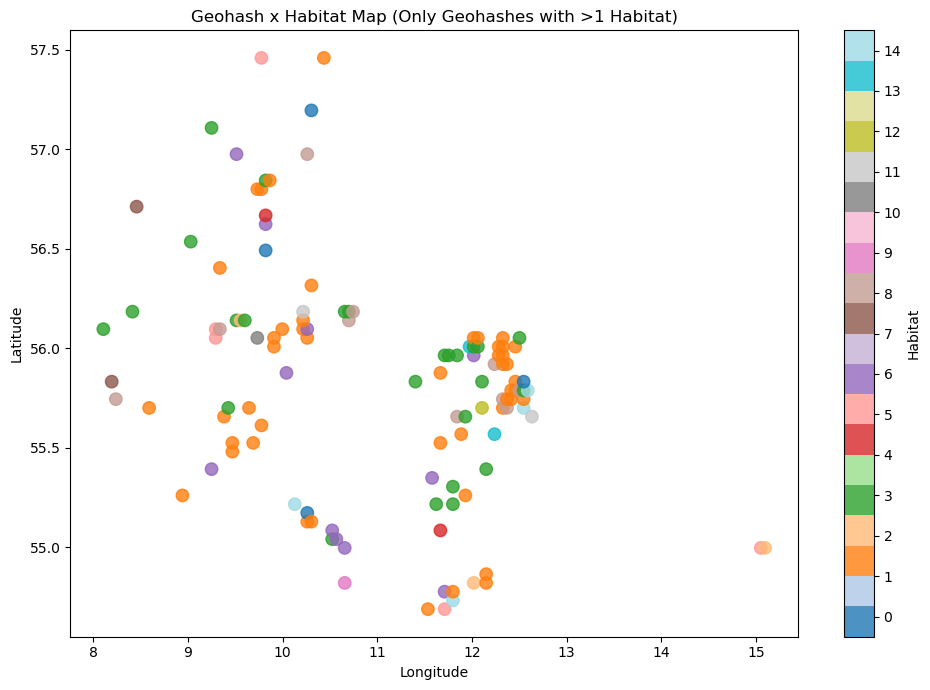

In [54]:
import geohash2

import matplotlib.pyplot as plt

# Only keep geohashes with more than one unique habitat
multi_hab_geohashes = proximity_summary[proximity_summary['unique_habitats'] > 1]['geohash']

# Create a pivot table: geohash x habitat counts, filtered
geo_hab_pivot = pd.pivot_table(
    df_feat[df_feat['geohash'].isin(multi_hab_geohashes)],
    index='geohash',
    columns='Habitat',
    values='filename_index',
    aggfunc='count',
    fill_value=0
)

# For visualization, sum across habitats to get the dominant habitat per geohash
dominant_habitat = geo_hab_pivot.idxmax(axis=1)
dominant_habitat = dominant_habitat.astype('category')
dominant_habitat_code = dominant_habitat.cat.codes

# Get geohash centroids for plotting
def geohash_centroid(gh):
    lat, lon, _, _ = geohash2.decode_exactly(gh)
    return lat, lon

geo_centroids = dominant_habitat.index.to_series().apply(geohash_centroid)
lats = geo_centroids.apply(lambda x: x[0])
lons = geo_centroids.apply(lambda x: x[1])

plt.figure(figsize=(10, 7))
sc = plt.scatter(lons, lats, c=dominant_habitat_code, cmap='tab20', s=80, alpha=0.8)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geohash x Habitat Map (Only Geohashes with >1 Habitat)')
plt.colorbar(sc, ticks=range(len(dominant_habitat.cat.categories)), label='Habitat')
plt.clim(-0.5, len(dominant_habitat.cat.categories)-0.5)
plt.tight_layout()
plt.show()

In [55]:
# Show habitats that overlap within geohashes (i.e., geohashes with more than one unique habitat)
overlap_geohashes = proximity_summary[proximity_summary['unique_habitats'] > 1]['geohash']

# For each overlapping geohash, list the habitats present
overlap_habitats = (
    df_feat[df_feat['geohash'].isin(overlap_geohashes)]
    .groupby('geohash')['Habitat']
    .unique()
)

# Display as a DataFrame for readability
overlap_habitats_df = overlap_habitats.reset_index().rename(columns={'Habitat': 'Habitats'})
overlap_habitats_df

,geohash,Habitats
0,u1vv5,"[coniferous woodland/plantation, natural grass..."
1,u1vvd,"[meadow, Willow scrubland]"
2,u1vz0,[Mixed woodland (with coniferous and deciduous...
3,u1vzx,"[coniferous woodland/plantation, Mixed woodlan..."
4,u1xxf,"[salt meadow, dune]"
...,...,...
115,u4p26,"[Deciduous woodland, Mixed woodland (with coni..."
116,u4p52,"[coniferous woodland/plantation, Deciduous woo..."
117,u4pk1,"[coniferous woodland/plantation, hedgerow]"
118,u4pm6,"[Unmanaged deciduous woodland, Unmanaged conif..."


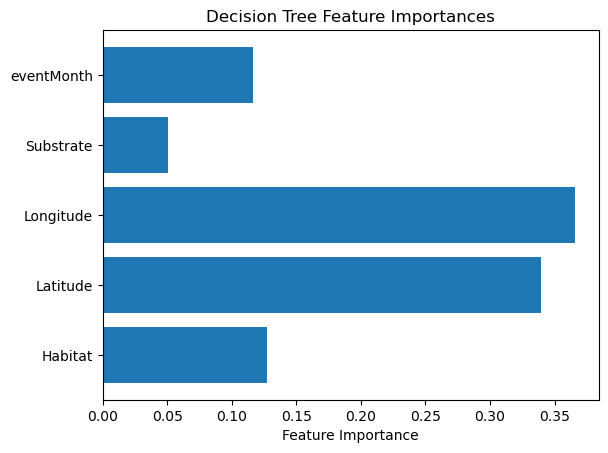

In [5]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

# Prepare the data
df = train_files_with_all_metadata.copy()

# Extract month from eventDate
df['eventMonth'] = pd.to_datetime(df['eventDate']).dt.month

# Encode categorical features
le_habitat = LabelEncoder()
le_substrate = LabelEncoder()
df['Habitat_enc'] = le_habitat.fit_transform(df['Habitat'])
df['Substrate_enc'] = le_substrate.fit_transform(df['Substrate'])

# Features and target
X = df[['Habitat_enc', 'Latitude', 'Longitude', 'Substrate_enc', 'eventMonth']]
y = df['taxonID_index']

# Train decision tree
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X, y)

# Plot feature importances
feature_names = ['Habitat', 'Latitude', 'Longitude', 'Substrate', 'eventMonth']
importances = clf.feature_importances_
plt.barh(feature_names, importances)
plt.xlabel('Feature Importance')
plt.title('Decision Tree Feature Importances')
plt.show()

## Feature engineering 

1. Cyclical dates (cos and sin)
2. geo block
3. seasonal geo
4. ...

In [ ]:
def standardise_lat_long(df):
    df = df.copy()
    lat_mean = df['Latitude'].mean()
    lat_std = df['Latitude'].std()
    long_mean = df['Longitude'].mean()
    long_std = df['Longitude'].std()
    df['Latitude_std'] = (df['Latitude'] - lat_mean) / lat_std
    df['Longitude_std'] = (df['Longitude'] - long_mean) / long_std
    return df

In [ ]:
def add_cyclic_month_features(df):
    df = df.copy()
    df['eventMonth_sin'] = np.sin(2 * np.pi * df['eventMonth'] / 12)
    df['eventMonth_cos'] = np.cos(2 * np.pi * df['eventMonth'] / 12)
    return df

In [19]:
import geohash2

def add_geohash_column(df, lat_col='Latitude', lon_col='Longitude', precision=5):
    df = df.copy()
    df['geohash'] = df.apply(lambda row: geohash2.encode(row[lat_col], row[lon_col], precision=precision), axis=1)
    return df

In [27]:
def add_geocell(df: pd.DataFrame, cell=0.1):
    latb = (df["Latitude"] / cell).round().astype("Int64")
    lonb = (df["Longitude"] / cell).round().astype("Int64")
    # robust to NaNs
    gc = np.where(latb.isna() | lonb.isna(), np.nan, latb.astype(str) + "_" + lonb.astype(str))
    df = df.copy()
    df["Geocell"] = gc
    return df

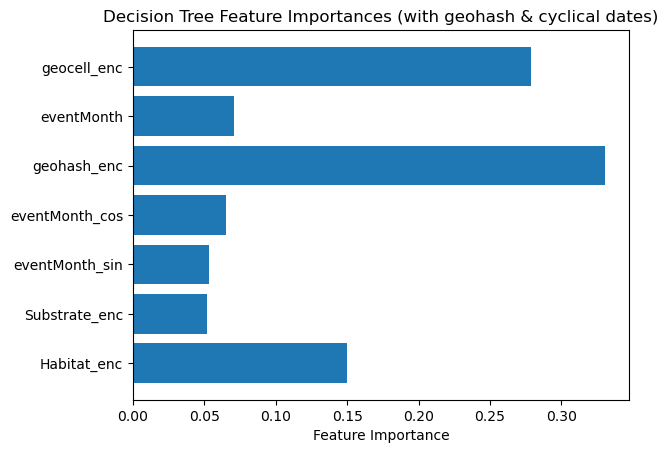

In [ ]:
df_feat = df.copy()

df_feat = add_geohash_column(df_feat)
df_feat = add_cyclic_month_features(df_feat)
df_feat = add_geocell(df_feat)

df_feat['geocell_enc'] = df_feat['Geocell'].astype('category').cat.codes
df_feat['geohash_enc'] = df_feat['geohash'].astype('category').cat.codes

# Prepare features including geohash and cyclical month
feature_cols = ['Habitat_enc', 'Substrate_enc', 'eventMonth_sin', 'eventMonth_cos', 'geohash_enc', 'eventMonth', 'geocell_enc']
X_feat = df_feat[feature_cols]
y_feat = df_feat['taxonID_index']

# Train decision tree
clf_feat = DecisionTreeClassifier(random_state=42)
clf_feat.fit(X_feat, y_feat)

# Plot feature importances
feature_names_feat = ['Habitat_enc', 'Substrate_enc', 'eventMonth_sin', 'eventMonth_cos', 'geohash_enc', 'eventMonth', 'geocell_enc']
importances_feat = clf_feat.feature_importances_
plt.barh(feature_names_feat, importances_feat)
plt.xlabel('Feature Importance')
plt.title('Decision Tree Feature Importances (with geohash & cyclical dates)')
plt.show()

Test 3 .. more robust

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GroupKFold
from sklearn.inspection import permutation_importance
import warnings
import pandas as pd

warnings.filterwarnings("ignore", category=UserWarning)

# Use precomputed features and encodings
X = df_feat[["Habitat", "Substrate", "geohash", "eventMonth_sin", "eventMonth_cos"]]
y = df_feat["taxonID_index"]
groups = df_feat["geohash"]

pre = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), ["Habitat", "Substrate", "geohash"]),
    ("num", "passthrough", ["eventMonth_sin", "eventMonth_cos"])
])

pipe = Pipeline([
    ("pre", pre),
    ("clf", DecisionTreeClassifier(random_state=42))
])

# Train a single decision tree on all data
pipe.fit(X, y)
# Get the trained DecisionTreeClassifier from the pipeline
model = pipe.named_steps["clf"]

# Get feature names after preprocessing
feat_names = pipe.named_steps["pre"].get_feature_names_out()

# Get feature importances
importances = model.feature_importances_

# Show top 20 features by importance
fi_df = pd.DataFrame({"feature": feat_names, "importance": importances})
fi_df = fi_df.sort_values("importance", ascending=False)
print(fi_df.head(20))

                                               feature  importance
498                                num__eventMonth_cos    0.076076
497                                num__eventMonth_sin    0.048353
375                                 cat__geohash_u3bwx    0.012432
365                                 cat__geohash_u3bw9    0.011973
40                                 cat__Substrate_wood    0.011277
7            cat__Habitat_Unmanaged deciduous woodland    0.011228
349                                 cat__geohash_u3bv6    0.010913
10         cat__Habitat_coniferous woodland/plantation    0.009204
233                                 cat__geohash_u38pn    0.008701
381                                 cat__geohash_u3by2    0.008397
358                                 cat__geohash_u3bvq    0.007761
81                                  cat__geohash_u1yex    0.007588
215                                 cat__geohash_u1zr2    0.007572
4    cat__Habitat_Mixed woodland (with coniferous a...    0.00

In [46]:
df_feat.Habitat.unique()

array(['Unmanaged deciduous woodland', 'Bog woodland',
       'Deciduous woodland', 'coniferous woodland/plantation',
       'Mixed woodland (with coniferous and deciduous trees)',
       'park/churchyard', 'Unmanaged coniferous woodland', 'lawn',
       'Acidic oak woodland', 'improved grassland', 'Thorny scrubland',
       'meadow', 'Forest bog', 'roadside', 'natural grassland', 'dune',
       'Willow scrubland', 'bog', 'heath', 'hedgerow', 'other habitat',
       'garden', 'salt meadow', 'wooded meadow, grazing forest',
       'gravel or clay pit'], dtype=object)